In [2]:
!pip install tld -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.8/263.8 kB 12.3 MB/s eta 0:00:00


In [44]:
import re # regex
from urllib.parse import urlparse
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('darkgrid')
matplotlib.rcParams['figure.figsize'] = (10, 6)

# ML libraries
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split as split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.metrics import classification_report, f1_score, recall_score, accuracy_score, roc_curve, confusion_matrix

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier, plot_importance

from pprint import pprint
from tld import get_tld, is_tld
from joblib import dump, load

In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
data_path = '/content/drive/MyDrive/malicious_phish.csv'
raw = pd.read_csv(data_path)
raw.head()



,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


#EDA 📚¶

In [6]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651191 entries, 0 to 651190
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     651191 non-null  object
 1   type    651191 non-null  object
dtypes: object(2)
memory usage: 9.9+ MB


In [7]:
raw['url_type'] = raw['type'].map({'benign': 0, 'defacement': 1, 'malware': 2, 'phishing': 3}).astype(np.int64)
raw.sample(5)

,url,type,url_type
604440,www.ultimatehawaii.com/Debara/,phishing,3
453920,amazon.com/Static-Contraction-Training-Peter-S...,benign,0
618962,www.irchelp.org/irchelp/nuke/,phishing,3
99501,securepaymente.com,phishing,3
214450,http://memil.kr/bbs/data/ebay.comm/sq1/sq/inde...,phishing,3


<ipython-input-8-f19ab1f31314>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=raw, x=raw.type, palette='tab20', width=.6, order=raw.type.value_counts().index)


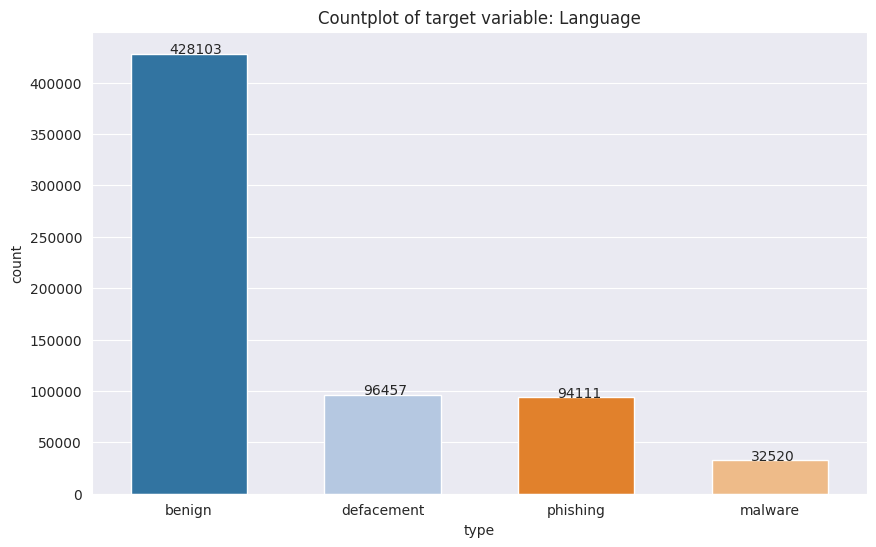

In [8]:
# Countplot
ax = sns.countplot(data=raw, x=raw.type, palette='tab20', width=.6, order=raw.type.value_counts().index)

for p, label in zip(ax.patches, raw.type.value_counts()):
    ax.annotate(label, (p.get_x() + .20, p.get_height() + 1))
ax.set_title('Countplot of target variable: Language')
plt.show()

In [9]:
def process_tld(url):
    try:
        res = get_tld(url, as_object=True, fail_silently=False, fix_protocol=True)
        domain = res.parsed_url.netloc
    except :
        domain = None
    return domain

In [10]:
# *** omit the (www.) from the URL which is in fact a sub domain in itself. ***
raw['url'] = raw['url'].replace('www', '', regex=True)
raw['url_length'] = raw['url'].apply(len)
raw['domain'] = raw['url'].apply(lambda x: process_tld(x))
raw.sample(10)

,url,type,url_type,url_length,domain
3314,youtube.com/watch?v=ZVYIBIlTIQs,benign,0,31,youtube.com
439229,http://.pastehtml.com/view/bq55ylshv.html,phishing,3,41,.pastehtml.com
239764,pt.goldenmap.com/Mesquite_(Nevada),benign,0,34,pt.goldenmap.com
84601,geneajourney.com/bchmp1.html,benign,0,28,geneajourney.com
266282,premjoshua.com/index.php?option=com_content&ta...,benign,0,69,premjoshua.com
141388,http://mueblescomuneros.com/recepcion/7-recepc...,defacement,1,90,mueblescomuneros.com
579250,paypal.com.us.login.run.object.cgi-bin.webscr....,benign,0,136,paypal.com.us.login.run.object.cgi-bin.webscr....
289849,fireinfive.com/index.html,benign,0,25,fireinfive.com
20495,en.wikipedia.org/wiki/Theo_van_Gogh_(film_dire...,benign,0,51,en.wikipedia.org
223372,http://wxztjz.com/e/public/onclick?enews=donew...,malware,2,65,wxztjz.com


In [11]:
feature = ['@','?','-','=','.','#','%','+','$','!','*',',','//']
for a in feature:
    raw[a] = raw['url'].apply(lambda i: i.count(a))
raw.head()

,url,type,url_type,url_length,domain,@,?,-,=,.,#,%,+,$,!,*,",",//
0,br-icloud.com.br,phishing,3,16,br-icloud.com.br,0,0,1,0,2,0,0,0,0,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,0,0,0,0,2,0,0,0,0,0,0,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,0,0,0,0,2,0,0,0,0,0,0,0,0
3,http://.garage-pirenne.be/index.php?option=com...,defacement,1,85,.garage-pirenne.be,0,1,1,4,3,0,0,0,0,0,0,0,1
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net,0,1,1,3,2,0,0,0,0,0,0,0,1


In [12]:
def abnormal_url(url: str) -> int:
    hostname = urlparse(url).hostname
    hostname = str(hostname)
    match = re.search(hostname, url)
    if match:
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0

In [13]:
raw['abnormal_url'] = raw['url'].apply(lambda x: abnormal_url(x))

<ipython-input-14-0a588b459bc5>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


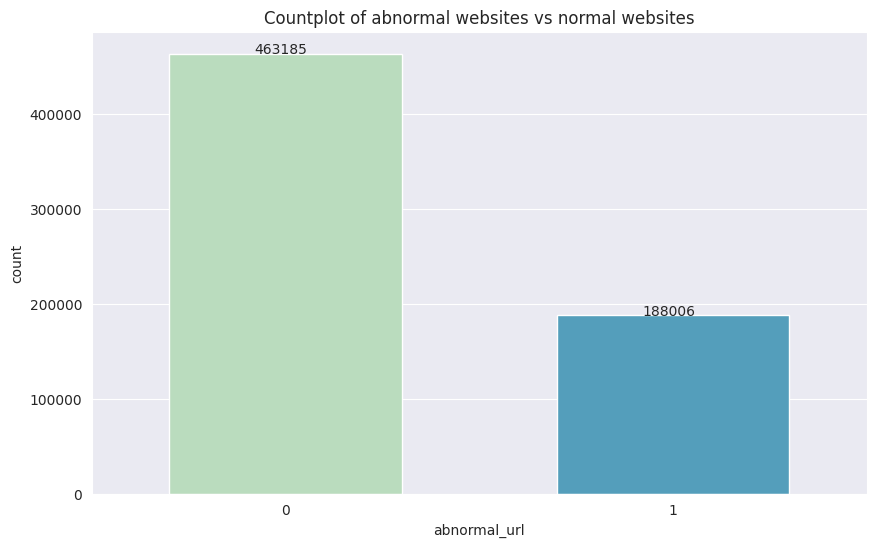

In [14]:
ax = sns.countplot(
    data=raw, x=raw.abnormal_url, palette='GnBu',width=.6, order=raw.abnormal_url.value_counts().index)

for p, label in zip(ax.patches, raw.abnormal_url.value_counts()):
    ax.annotate(label, (p.get_x() + .22, p.get_height() + 1))
ax.set_title('Countplot of abnormal websites vs normal websites')
plt.show()

In [15]:
def httpSecured(url: str) -> int:
    htp = urlparse(url).scheme
    match = str(htp)
    if match == 'https':
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0

In [16]:
raw['https'] = raw['url'].apply(lambda x: httpSecured(x))

<ipython-input-17-dfd73f00f1d2>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=raw, x=raw.https, palette='GnBu',width=.6, order=raw.https.value_counts().index)


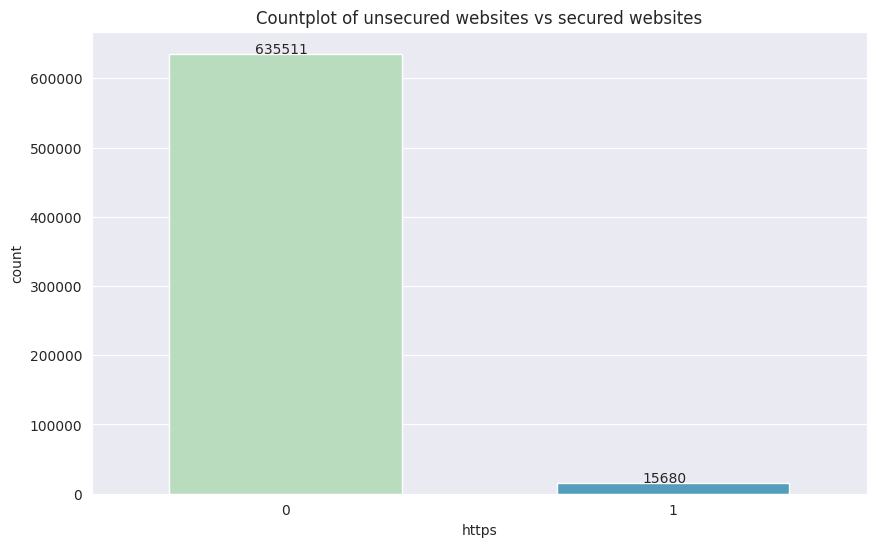

In [17]:
ax = sns.countplot(data=raw, x=raw.https, palette='GnBu',width=.6, order=raw.https.value_counts().index)

for p, label in zip(ax.patches, raw.https.value_counts()):
    ax.annotate(label, (p.get_x() + .22, p.get_height() + 1))
ax.set_title('Countplot of unsecured websites vs secured websites')
plt.show()

In [18]:
def digit_count(url: str) -> int:
    digits = 0
    for i in url:
        if i.isnumeric():
            digits = digits + 1
    return digits

# Counts the number of letter characters in a URL
def letter_count(url: str) -> int:
    letters = 0
    for i in url:
        if i.isalpha():
            letters = letters + 1
    return letters

In [19]:
raw['digits']  = raw['url'].apply(lambda x: digit_count(x))
raw['letters'] = raw['url'].apply(lambda x: letter_count(x))

In [20]:
raw.sample(10)

,url,type,url_type,url_length,domain,@,?,-,=,.,...,+,$,!,*,",",//,abnormal_url,https,digits,letters
323980,flixster.com/movie/made-in-canada,benign,0,33,flixster.com,0,0,2,0,1,...,0,0,0,0,0,0,0,0,0,28
611843,.specialchem4coatings.com/resources/glossary/i...,phishing,3,55,.specialchem4coatings.com,0,0,0,0,3,...,0,0,0,0,0,0,0,0,1,48
492842,http://.babolna.eu/index.php?option=com_conten...,defacement,1,122,.babolna.eu,0,1,0,7,3,...,0,0,0,0,0,1,1,0,8,88
45496,sabrenoise.com/2011/10/06/buffalo-sabres-2011-...,benign,0,64,sabrenoise.com,0,0,5,0,1,...,0,0,0,0,0,0,0,0,14,39
344136,ech.case.edu/ech-cgi/article.pl?id=KEA,benign,0,38,ech.case.edu,0,1,1,1,3,...,0,0,0,0,0,0,0,0,0,30
84548,campuspitch.com/,benign,0,16,campuspitch.com,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,14
518129,http://.andriacambia.it/index.php?option=com_c...,defacement,1,95,.andriacambia.it,0,1,0,5,3,...,0,0,0,0,0,1,1,0,5,72
310524,picsearch.com/pictures/Vehicles/Ships/Canadian...,benign,0,85,picsearch.com,0,0,0,0,2,...,0,0,0,0,0,0,0,0,6,69
121608,http://.tev-bruchsal.de/index.php?view=article...,defacement,1,137,.tev-bruchsal.de,0,1,1,8,3,...,0,0,0,0,0,1,1,0,5,106
524149,https://semanagarantidamesdasmaes.com/american...,phishing,3,95,semanagarantidamesdasmaes.com,0,1,0,2,1,...,0,0,0,0,0,1,1,1,20,64


In [21]:
# ** Checks to see whether URL contains a shortening service **
def shortening_service(url: str) -> int:
    match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      'tr\.im|link\.zip\.net',
                      url)
    if match:
        return 1
    else:
        return 0

In [22]:
raw['shortening_service'] = raw['url'].apply(lambda x: shortening_service(x))

<ipython-input-23-3425e4296ba2>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


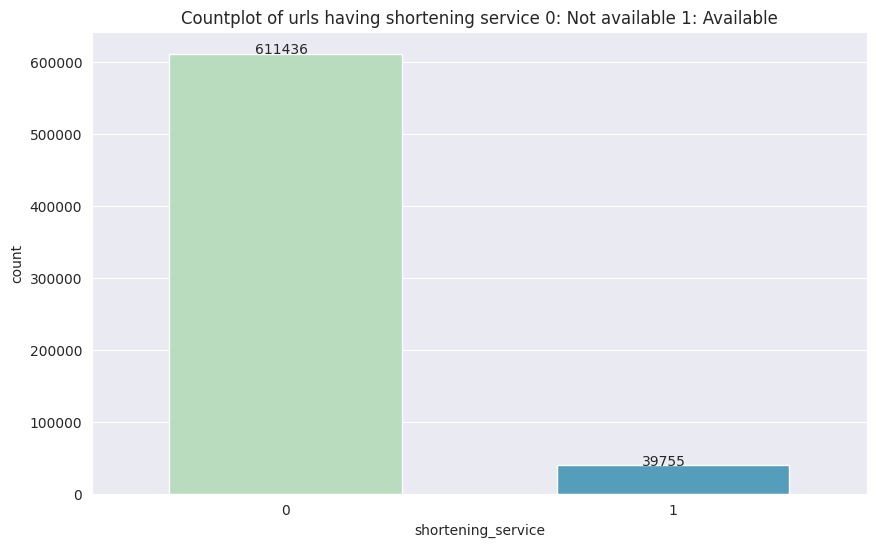

In [23]:
ax = sns.countplot(
    data=raw,
    x=raw.shortening_service,
    palette='GnBu',
    width=.6,
    order=raw.shortening_service.value_counts().index)

for p, label in zip(ax.patches, raw.shortening_service.value_counts()):
    ax.annotate(label, (p.get_x() + .22, p.get_height() + 1))
ax.set_title('Countplot of urls having shortening service 0: Not available 1: Available')
plt.show()

In [24]:
def having_ip_address(url: str) -> int:
    match = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4 with port
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}|'
        '([0-9]+(?:\.[0-9]+){3}:[0-9]+)|'
        '((?:(?:\d|[01]?\d\d|2[0-4]\d|25[0-5])\.){3}(?:25[0-5]|2[0-4]\d|[01]?\d\d|\d)(?:\/\d{1,2})?)', url)  # Ipv6
    if match:
        return 1
    else:
        return 0

In [25]:
raw['has_ip_address'] = raw['url'].apply(lambda x: having_ip_address(x))
raw.has_ip_address.value_counts()

,count
has_ip_address,
0,638703
1,12488


<ipython-input-26-ea04b2a60fa3>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


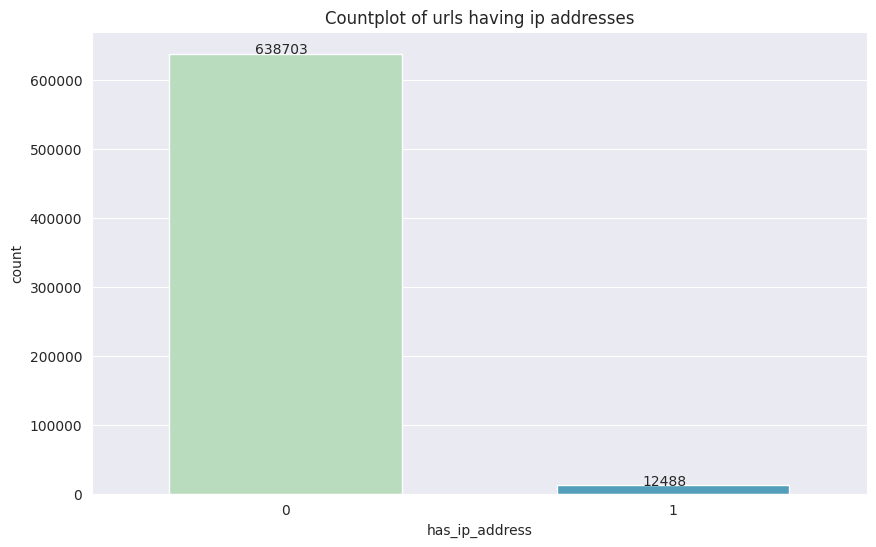

In [26]:
ax = sns.countplot(
    data=raw,
    x=raw.has_ip_address,
    palette='GnBu',
    width=.6,
    order=raw.has_ip_address.value_counts().index)

for p, label in zip(ax.patches, raw.has_ip_address.value_counts()):
    ax.annotate(label, (p.get_x() + .22, p.get_height() + 1))
ax.set_title('Countplot of urls having ip addresses')
plt.show()

#Correlation Plot: HeatMap 📍¶

In [27]:
raw.head()

,url,type,url_type,url_length,domain,@,?,-,=,.,...,!,*,",",//,abnormal_url,https,digits,letters,shortening_service,has_ip_address
0,br-icloud.com.br,phishing,3,16,br-icloud.com.br,0,0,1,0,2,...,0,0,0,0,0,0,0,13,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,0,0,0,0,2,...,0,0,0,0,0,0,1,29,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,0,0,0,0,2,...,0,0,0,0,0,0,1,25,0,0
3,http://.garage-pirenne.be/index.php?option=com...,defacement,1,85,.garage-pirenne.be,0,1,1,4,3,...,0,0,0,1,1,0,7,60,0,0
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net,0,1,1,3,2,...,0,0,0,1,1,0,22,199,0,0


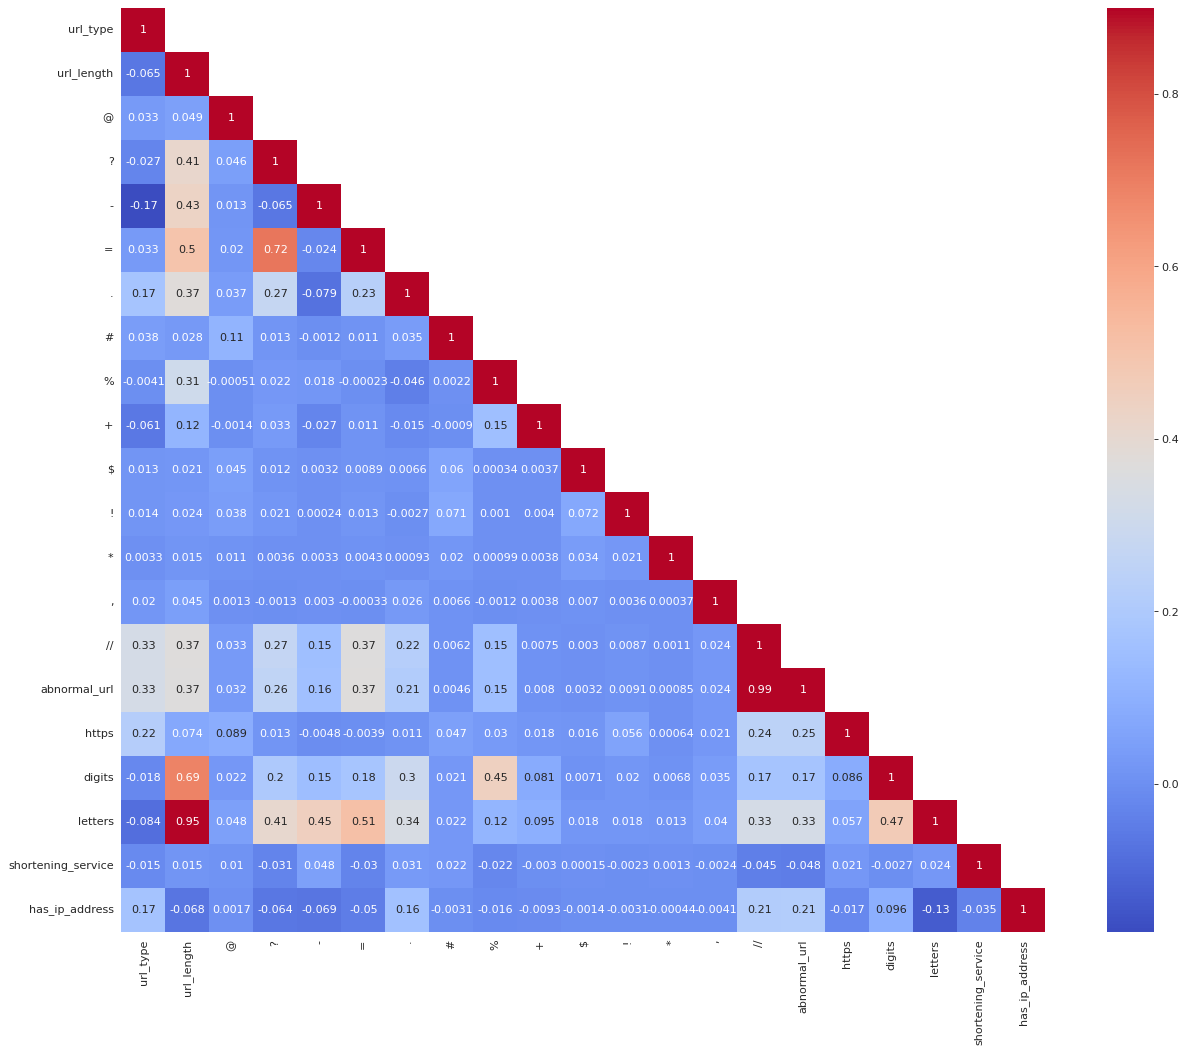

In [28]:
numeric_cols = [
    col for col in raw.columns if raw[col].dtype in ['int', 'float']
]

corr = raw[numeric_cols].corr()
mask = np.array(corr)
mask[np.tril_indices_from(mask)] = False;

sns.set_style('whitegrid')
plt.figure(figsize = (20, 15), dpi = 80)
sns.heatmap(corr, mask = mask, square = True, annot = True, vmax = .9, cmap = 'coolwarm')
plt.grid(False)
plt.show()

In [29]:
# - features to remove
# url, type, domain
# - features to keep for model training
# numeric_cols, url_type <- target variable

target = raw[numeric_cols].pop('url_type')
inputs = raw[numeric_cols].drop(columns='url_type', axis=1)

In [30]:
scaler = StandardScaler().fit(raw[inputs.columns.to_list()])
raw[inputs.columns.to_list()] = scaler.transform(raw[inputs.columns.to_list()])
raw[inputs.columns.to_list()]

,url_length,@,?,-,=,.,#,%,+,$,!,*,",",//,abnormal_url,https,digits,letters,shortening_service,has_ip_address
0,-0.977485,-0.040954,-0.507190,-0.185091,-0.398075,-0.131112,-0.026935,-0.116422,-0.110147,-0.01011,-0.024114,-0.005267,-0.031644,-0.633895,-0.637101,-0.157077,-0.472396,-1.007653,-0.254988,-0.139829
1,-0.551230,-0.040954,-0.507190,-0.521362,-0.398075,-0.131112,-0.026935,-0.116422,-0.110147,-0.01011,-0.024114,-0.005267,-0.031644,-0.633895,-0.637101,-0.157077,-0.386931,-0.498432,-0.254988,-0.139829
2,-0.640968,-0.040954,-0.507190,-0.521362,-0.398075,-0.131112,-0.026935,-0.116422,-0.110147,-0.01011,-0.024114,-0.005267,-0.031644,-0.633895,-0.637101,-0.157077,-0.386931,-0.625737,-0.254988,-0.139829
3,0.570493,-0.040954,1.759256,-0.185091,2.238780,0.539700,-0.026935,-0.116422,-0.110147,-0.01011,-0.024114,-0.005267,-0.031644,1.529649,1.569609,-0.157077,0.125854,0.488186,-0.254988,-0.139829
4,3.935662,-0.040954,1.759256,-0.185091,1.579567,-0.131112,-0.026935,-0.116422,-0.110147,-0.01011,-0.024114,-0.005267,-0.031644,1.529649,1.569609,-0.157077,1.407817,4.912049,-0.254988,-0.139829
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651186,-0.461492,-0.040954,-0.507190,-0.521362,-0.398075,0.539700,-0.026935,-0.116422,-0.110147,-0.01011,-0.024114,-0.005267,-0.031644,-0.633895,-0.637101,-0.157077,0.553175,-0.753042,-0.254988,-0.139829
651187,-0.349320,-0.040954,-0.507190,0.151181,-0.398075,-0.131112,-0.026935,-0.116422,-0.110147,-0.01011,-0.024114,-0.005267,-0.031644,-0.633895,-0.637101,-0.157077,0.125854,-0.498432,3.921747,-0.139829
651188,-0.461492,-0.040954,-0.507190,-0.521362,-0.398075,-0.131112,-0.026935,-0.116422,-0.110147,-0.01011,-0.024114,-0.005267,-0.031644,-0.633895,-0.637101,-0.157077,-0.216003,-0.466605,3.921747,-0.139829
651189,-0.326886,-0.040954,-0.507190,-0.521362,-0.398075,-0.131112,-0.026935,-0.116422,-0.110147,-0.01011,-0.024114,-0.005267,-0.031644,-0.633895,-0.637101,-0.157077,-0.472396,-0.275647,-0.254988,-0.139829


In [31]:
raw_sampled = raw[numeric_cols].sample(n=70_000)
raw_sampled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 70000 entries, 554175 to 594122
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   url_type            70000 non-null  int64  
 1   url_length          70000 non-null  float64
 2   @                   70000 non-null  float64
 3   ?                   70000 non-null  float64
 4   -                   70000 non-null  float64
 5   =                   70000 non-null  float64
 6   .                   70000 non-null  float64
 7   #                   70000 non-null  float64
 8   %                   70000 non-null  float64
 9   +                   70000 non-null  float64
 10  $                   70000 non-null  float64
 11  !                   70000 non-null  float64
 12  *                   70000 non-null  float64
 13  ,                   70000 non-null  float64
 14  //                  70000 non-null  float64
 15  abnormal_url        70000 non-null  float64
 16  htt

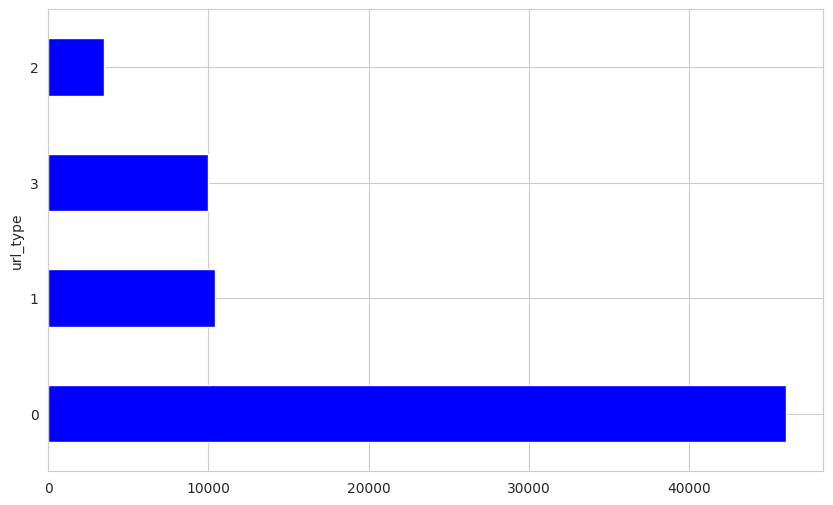

In [36]:
raw_sampled.url_type.value_counts().plot.barh(color='blue');

In [35]:
train_inputs, test_inputs, train_target, test_target = split(
    raw_sampled[inputs.columns], raw_sampled.url_type, test_size=.40, stratify=raw_sampled.url_type, random_state=42)
print(
    f"Train shape: {train_inputs.shape} | Target shape: {train_target.shape}",
    f"Test shape: {test_inputs.shape} | Test target shape: {test_target.shape}",
    sep="\n",
)

Train shape: (42000, 20) | Target shape: (42000,)
Test shape: (28000, 20) | Test target shape: (28000,)


#Features Selection 👾¶

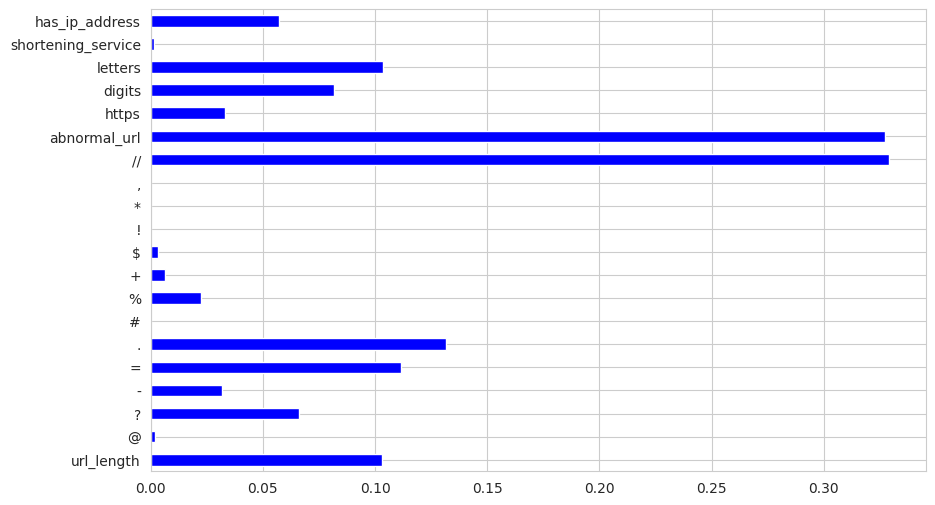

In [37]:
importances = mutual_info_classif(train_inputs, train_target)
feat_importances = pd.Series(importances, train_inputs.columns)
feat_importances.plot(kind='barh', color='blue');

#Experiments

In [38]:
def train(model, X, y, average: str = 'macro') -> None:
    preds = model.predict(X)
    metric_summary(y, preds, average)

def metric_summary(y, preds, average) -> None:
    acc = accuracy_score(y, preds)
    f1 = f1_score(y, preds, average=average)
    rcl = recall_score(y, preds, average=average)
    print(
        f"Accuracy: {(acc * 100):.2f} %",
        f"f1: {f1:.2f}",
        f"recall: {rcl:.2f}", sep="\n"
    )

In [39]:
rffst = RandomForestClassifier(random_state=42).fit(train_inputs, train_target)
train(model=rffst, X=test_inputs, y=test_target)

Accuracy: 91.00 %
f1: 0.87
recall: 0.85


In [40]:
n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=10)]
max_features = ['sqrt', 'log2']
max_depth = [int(x) for x in np.linspace(start=10, stop=110, num=11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf  = [1, 2, 4]
bootstrap = [True, False]
criterion = ['gini', 'entropy']

random_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap,
    'criterion': criterion,
}

rf_ = RandomForestClassifier()

rf_cv = RandomizedSearchCV(
    estimator=rf_,
    param_distributions=random_grid,
    n_iter=5,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

rf_cv.fit(train_inputs, train_target)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=5,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [41]:
pprint(rf_cv.best_params_)

{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': 50,
 'max_features': 'log2',
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'n_estimators': 200}


In [46]:
def test_params(model, average: str='macro', **params) -> None:
    model = model(random_state=42, n_jobs=-1, **params).fit(train_inputs, train_target)
    train(model, test_inputs, test_target, average)
    return

In [47]:
test_params(
    model=RandomForestClassifier,
    n_estimators=200,
    min_samples_split=10,
    min_samples_leaf=2,
    max_features='log2',
    max_depth=50,
    criterion='gini',
    bootstrap=True,
)

Accuracy: 90.06 %
f1: 0.84
recall: 0.82


In [48]:
test_params(
    model=XGBClassifier,
    n_estimators=200,
    min_samples_split=10,
    min_samples_leaf=2,
    max_features='log2',
    max_depth=50,
    criterion='gini',
    bootstrap=True,
    average='weighted',
)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:47:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "bootstrap", "criterion", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 90.53 %
f1: 0.90
recall: 0.91


In [49]:
test_params(
    model=XGBClassifier,
    n_estimators=200,
    max_depth=50,
)

Accuracy: 90.53 %
f1: 0.86
recall: 0.85


***** lg *****


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test Accuracy : 82.65% 
              Classification Report 
              precision    recall  f1-score   support

           0       0.84      0.97      0.90     18432
           1       0.79      0.94      0.86      4169
           2       0.83      0.69      0.76      1399
           3       0.53      0.08      0.14      4000

    accuracy                           0.83     28000
   macro avg       0.75      0.67      0.66     28000
weighted avg       0.79      0.83      0.78     28000

             Confusion Matrix 


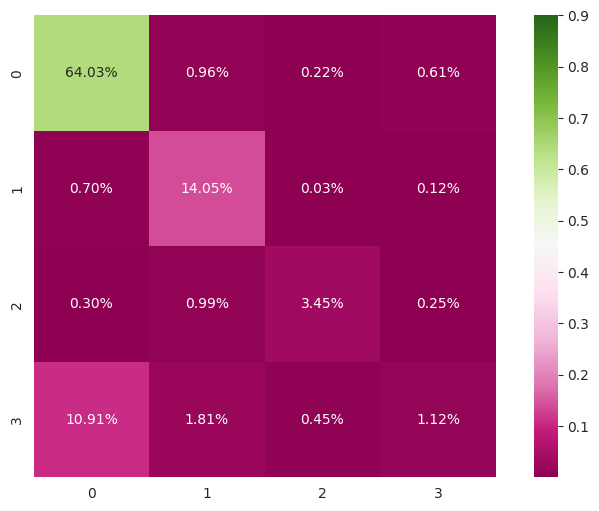

********************** END **********************
***** lgcv *****


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Test Accuracy : 82.64% 
              Classification Report 
              precision    recall  f1-score   support

           0       0.84      0.97      0.90     18432
           1       0.79      0.94      0.86      4169
           2       0.83      0.69      0.75      1399
           3       0.52      0.08      0.14      4000

    accuracy                           0.83     28000
   macro avg       0.75      0.67      0.66     28000
weighted avg       0.79      0.83      0.78     28000

             Confusion Matrix 


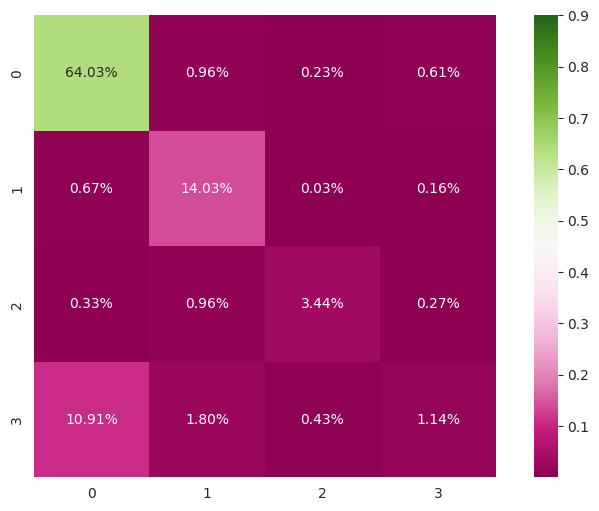

********************** END **********************
***** tree *****
Test Accuracy : 89.48% 
              Classification Report 
              precision    recall  f1-score   support

           0       0.93      0.95      0.94     18432
           1       0.90      0.92      0.91      4169
           2       0.87      0.86      0.86      1399
           3       0.70      0.63      0.66      4000

    accuracy                           0.89     28000
   macro avg       0.85      0.84      0.84     28000
weighted avg       0.89      0.89      0.89     28000

             Confusion Matrix 


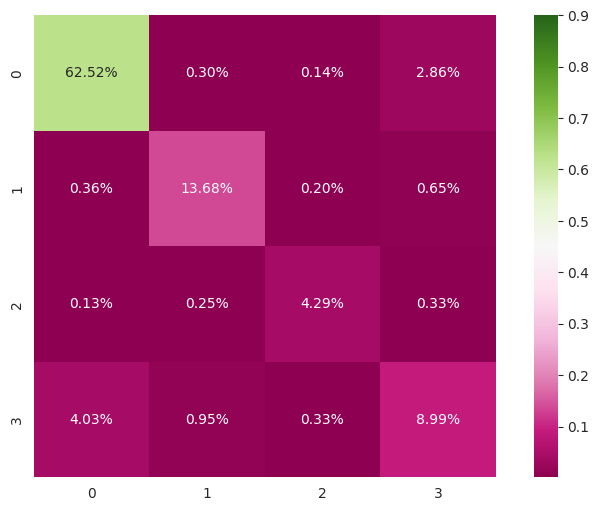

********************** END **********************
***** forest *****
Test Accuracy : 91.00% 
              Classification Report 
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     18432
           1       0.91      0.95      0.93      4169
           2       0.93      0.86      0.90      1399
           3       0.76      0.64      0.69      4000

    accuracy                           0.91     28000
   macro avg       0.89      0.85      0.87     28000
weighted avg       0.91      0.91      0.91     28000

             Confusion Matrix 


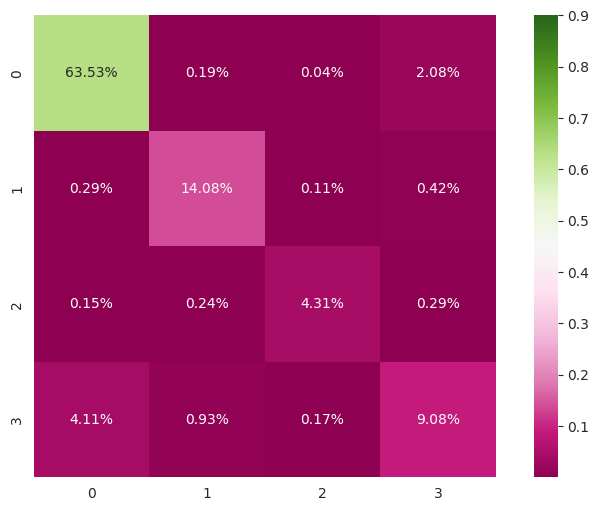

********************** END **********************
***** extas *****
Test Accuracy : 90.83% 
              Classification Report 
              precision    recall  f1-score   support

           0       0.93      0.96      0.95     18432
           1       0.91      0.95      0.93      4169
           2       0.92      0.87      0.89      1399
           3       0.76      0.63      0.69      4000

    accuracy                           0.91     28000
   macro avg       0.88      0.85      0.86     28000
weighted avg       0.90      0.91      0.90     28000

             Confusion Matrix 


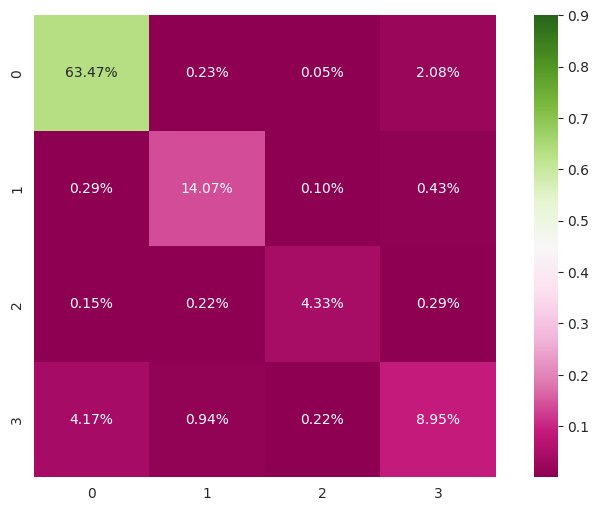

********************** END **********************
***** xgb *****
Test Accuracy : 90.15% 
              Classification Report 
              precision    recall  f1-score   support

           0       0.92      0.97      0.94     18432
           1       0.90      0.96      0.93      4169
           2       0.93      0.84      0.88      1399
           3       0.78      0.54      0.64      4000

    accuracy                           0.90     28000
   macro avg       0.88      0.83      0.85     28000
weighted avg       0.90      0.90      0.89     28000

             Confusion Matrix 


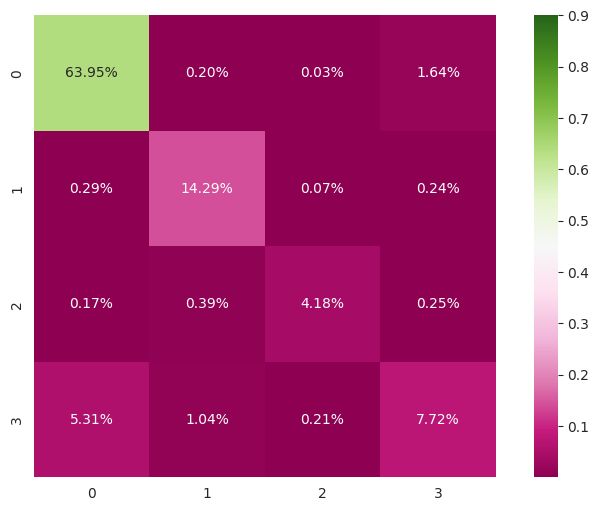

********************** END **********************
Meilleur modèle sauvegardé avec une précision de 91.00%


In [52]:
estimators = [
    ('lg', LogisticRegression(random_state=42)),
    ('lgcv', LogisticRegressionCV(random_state=42)),
    ('tree', DecisionTreeClassifier(random_state=42)),
    ('forest', RandomForestClassifier(random_state=42)),
    ('extas', ExtraTreesClassifier(random_state=42)),
    ('xgb', XGBClassifier(random_state=42)),
]

best_model = None
best_accuracy = 0

test_accuracies = list()

for name, model in estimators:
    print(f"***** {name} *****")
    model.fit(train_inputs, train_target)
    preds = model.predict(test_inputs)
    accuracy = accuracy_score(test_target, preds)
    test_accuracies.append(accuracy)

    print(f'Test Accuracy :\033[32m \033[01m{accuracy * 100:.2f}%\033[30m \033[0m')
    print('\033[01m              Classification Report \033[0m')
    print(classification_report(test_target, preds))

    print('\033[01m             Confusion Matrix \033[0m')
    cf_matrix = confusion_matrix(test_target, preds)
    plot_ = sns.heatmap(
        cf_matrix / np.sum(cf_matrix), annot=True, square=True, vmax=.9, fmt='0.2%', cmap='PiYG'
    )
    plt.show()

    # Si la précision du modèle est meilleure que la précédente
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model  # Sauvegarder le meilleur modèle

    print("********************** END **********************")

# Sauvegarder le meilleur modèle avec joblib
if best_model:
    dump(best_model, 'best_model.pkl')
    print(f"Meilleur modèle sauvegardé avec une précision de {best_accuracy * 100:.2f}%")


In [55]:
!ls

best_model.pkl	drive  sample_data
